In [2]:
import shap

shap.initjs()

In [3]:
from typing import Protocol

from pandas import DataFrame
from numpy.typing import NDArray

class Model(Protocol):
    def fit(self, x: DataFrame | NDArray, y: DataFrame | NDArray) -> 'Model':
        pass
    
    def predict(self, x: DataFrame | NDArray) -> NDArray:
        pass
    
    def predict_proba(self, x: DataFrame | NDArray) -> NDArray:
        pass

In [4]:
import pickle

def load_model(name: str) -> Model:
    with open(f'../models/{name}.pkl', 'rb') as file:
        return pickle.load(file)

In [5]:
import shap

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


explainers = {
    CatBoostClassifier: shap.TreeExplainer,
    AdaBoostClassifier: shap.TreeExplainer,
    RandomForestClassifier: shap.TreeExplainer,
    DecisionTreeClassifier: shap.TreeExplainer,
    LogisticRegression: shap.LinearExplainer,
}

def make_explainer(model: Model) -> shap.Explainer:
    assert model in explainers
    return explainers[type(model)](model)

In [6]:
logreg = load_model('LogisticRegression')

In [7]:
from pandas import read_csv

data = read_csv('../data/processed/data.csv').drop(columns=['EmployeeID', 'Unnamed: 0'])

In [8]:
TARGET = 'Attrition_Yes'
assert TARGET in data.columns

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=[TARGET]), data[TARGET])

In [10]:
logreg = logreg.fit(x_train, y_train)

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logreg_bad = Pipeline(steps=[
    (
        'Fill missing values',
        SimpleImputer(strategy='median')  # can use median as there are no missing categorical features
    ),
    (
        'Scaling',
        StandardScaler()
    ),
    (
        'Model',
        LogisticRegression(penalty=None, solver='sag', max_iter=10000)
    )
]).fit(x_train, y_train)

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, logreg.predict(x_test)), accuracy_score(y_test, logreg_bad.predict(x_test))

(0.8504079782411604, 0.8513145965548504)

In [13]:
accuracy_score(y_train, logreg.predict(x_train)), accuracy_score(y_train, logreg_bad.predict(x_train))

(0.8599939522225583, 0.8602963410946477)

In [14]:
import numpy as np

from pandas import DataFrame
from plotly.express import bar


def plot_feature_importance(importances: np.ndarray[float], classifier: str) -> None:
    bar(DataFrame({
        'y': importances
    }, index=x_train.columns).sort_values(by='y'), labels={
        'x': 'Feature importance',
        'y': 'Feature name'
    }, orientation='h', height=1000, title=classifier + ' feature importance').show()

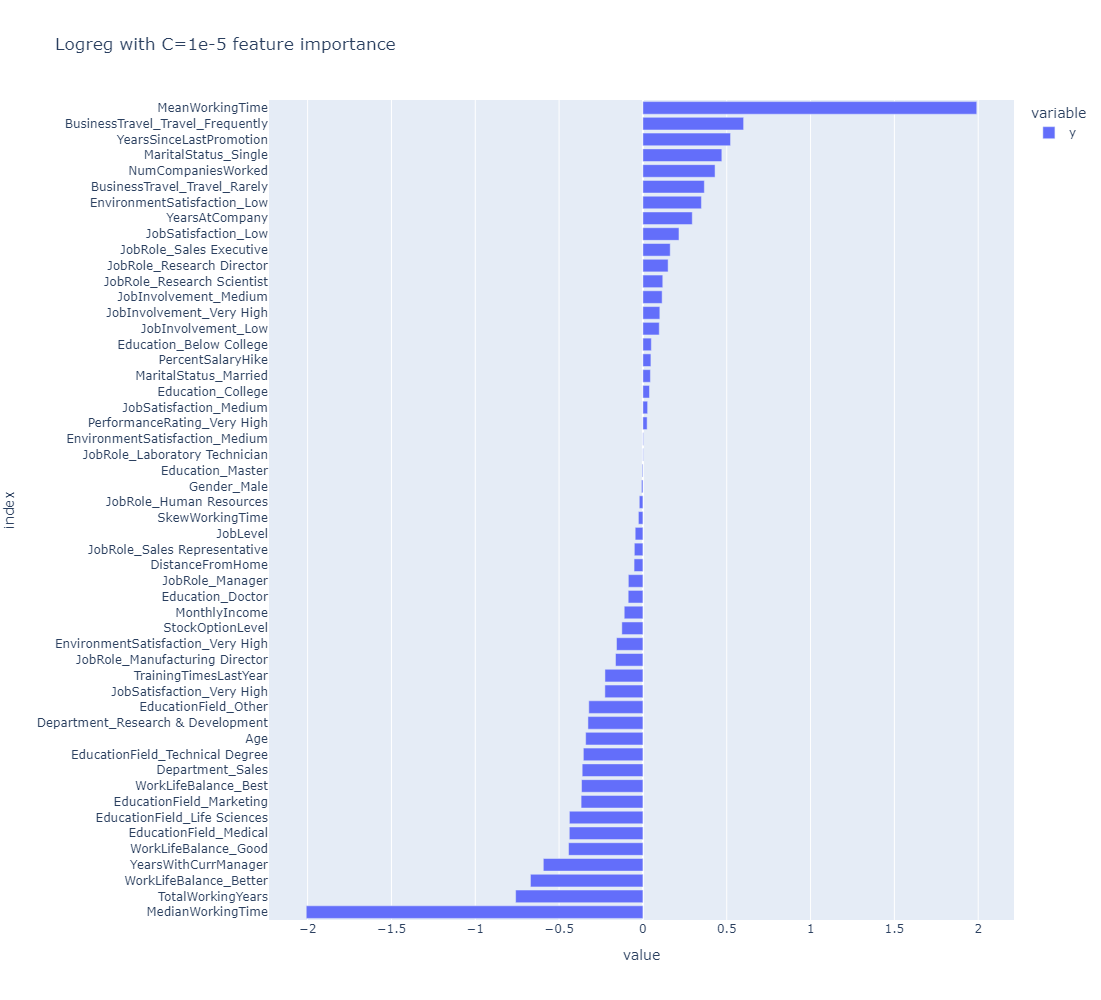

In [15]:
plot_feature_importance(logreg_bad[-1].coef_.reshape(-1), 'Logreg with C=1e-5')

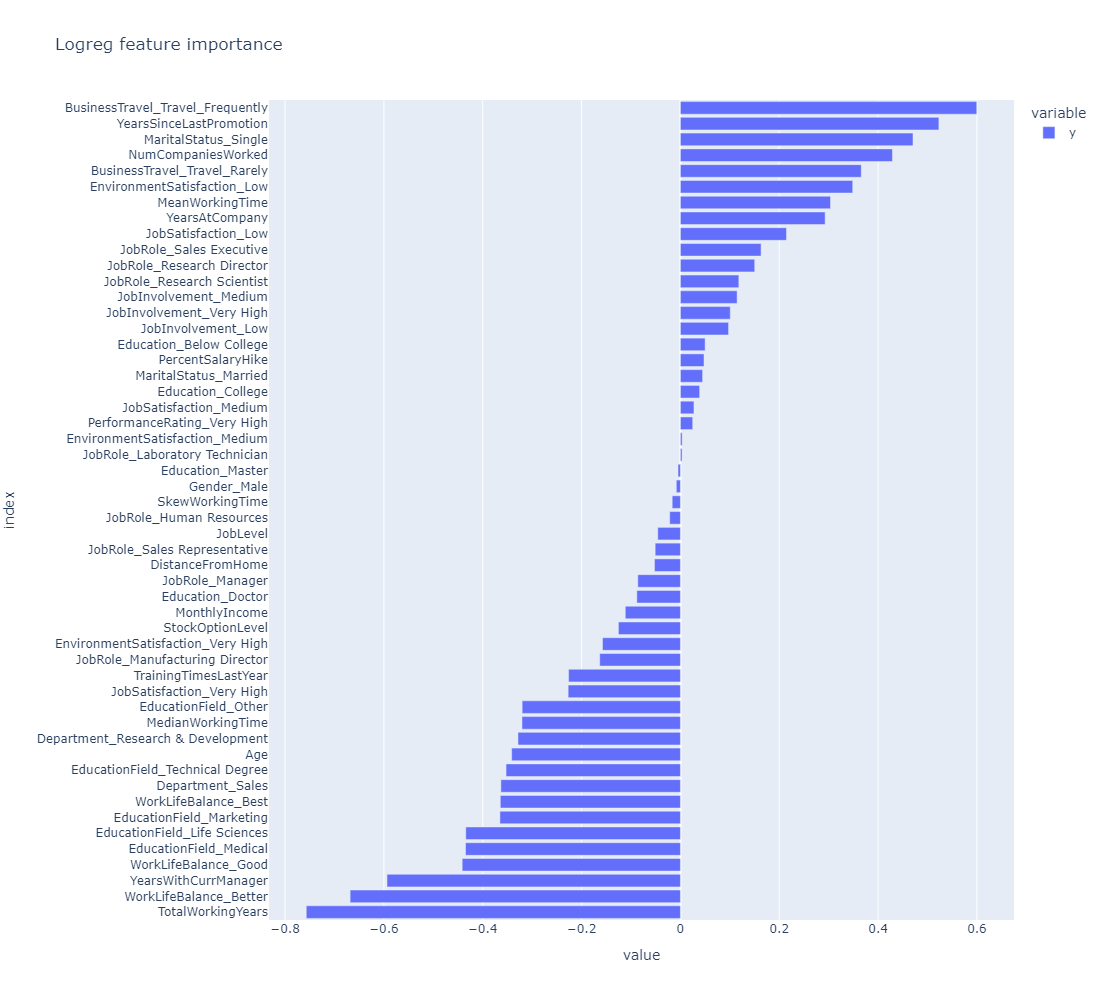

In [16]:
plot_feature_importance(logreg[-1].coef_.reshape(-1), 'Logreg')

In [17]:
catboost = load_model('CatBoostClassifier')

In [18]:
explainer = shap.TreeExplainer(catboost[-1])

In [19]:
from pandas import read_csv
from sklearn.model_selection import train_test_split

data = read_csv('../data/processed/data.csv')

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=[TARGET]), data[TARGET])

In [20]:
explained = explainer(X=catboost[:-1].transform(x_test), y=y_test)

In [21]:
shap.plots.force(explained)